# Facial Emotion Recognition | Fine-tuned VGG19 Model - CK+ Dataset

In [8]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Conv2D, GlobalAveragePooling2D
from tensorflow.keras.layers import Dropout, BatchNormalization, Activation
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import seaborn as sns
from matplotlib import pyplot
import pandas as pd
import scikitplot

In [9]:
import matplotlib.pyplot as plt
import os
import cv2
from tqdm import tqdm
import numpy as np
DATADIR = "/kaggle/input/ckcroped"

CATEGORIES = ["angry", "neutral", "disgust", "fear", "happy", "sadness", "surprise"]

IMG_SIZE = 200
training_data = []

def create_training_data():
    for category in CATEGORIES: 

        path = os.path.join(DATADIR,category)  
        class_num = CATEGORIES.index(category)  
        
        print(str(class_num)+" => "+category)

        for img in tqdm(os.listdir(path)):  # iterate over each image per dogs and cats
            try:
                #new_array = readTransparentImg(os.path.join(path,img),IMG_SIZE)
                img_array = cv2.imread(os.path.join(path,img))  # convert to array
                new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))  # resize to normalize data size
                training_data.append([new_array, class_num])  # add this to our training_data

            except Exception as e:  # in the interest in keeping the output clean...
                pass
                print(e)
            #except OSError as e:
            #    print("OSErrroBad img most likely", e, os.path.join(path,img))
            #except Exception as e:
            #    print("general exception", e, os.path.join(path,img))
            
create_training_data()

print(len(training_data))

0 => angry


100%|██████████| 899/899 [00:02<00:00, 369.56it/s]


1 => neutral


100%|██████████| 233/233 [00:00<00:00, 354.48it/s]


2 => disgust


100%|██████████| 857/857 [00:02<00:00, 377.30it/s]


3 => fear


100%|██████████| 546/546 [00:01<00:00, 402.74it/s]


4 => happy


100%|██████████| 1331/1331 [00:03<00:00, 399.43it/s]


5 => sadness


100%|██████████| 547/547 [00:01<00:00, 386.82it/s]


6 => surprise


100%|██████████| 273/273 [00:00<00:00, 340.68it/s]

4686


In [10]:
np.array(training_data).shape

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  """Entry point for launching an IPython kernel.


(4686, 2)

In [11]:
import random
import pickle
random.shuffle(training_data)
A_D= []
B_D= []
for features,label in training_data:
    A_D.append(features)
    B_D.append(label)

A_D= np.array(A_D).reshape(-1, IMG_SIZE, IMG_SIZE, 3)

pickle_out = open("A_D.pickle","wb")
pickle.dump(A_D, pickle_out)
pickle_out.close()

pickle_out = open("B_D.pickle","wb")
pickle.dump(B_D, pickle_out)
pickle_out.close()

In [12]:
print(np.array(B_D).shape)

(4686,)


In [13]:
img_features = A_D


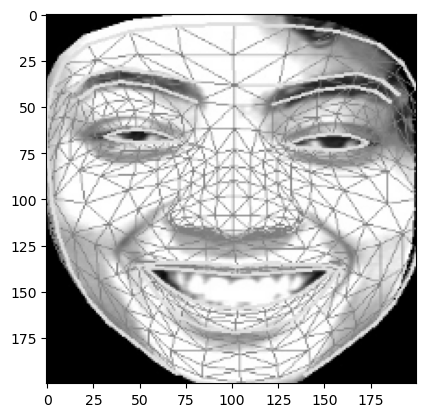

In [14]:
plt.imshow(img_features[0].astype(np.uint8));

In [15]:
le = LabelEncoder()

img_labels = le.fit_transform(B_D)#df.emotion
img_labels = to_categorical(img_labels)
img_labels.shape

(4686, 7)

In [16]:
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(le_name_mapping)

{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6}


In [17]:
#Setup training
X_train, X_valid, y_train, y_valid = train_test_split(img_features, 
                                                      img_labels, 
                                                      shuffle = True, 
                                                      stratify = img_labels, 
                                                      random_state = 42)
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((4217, 200, 200, 3), (469, 200, 200, 3), (4217, 7), (469, 7))

In [18]:
img_width = X_train.shape[1]
img_height = X_train.shape[2]
img_depth = X_train.shape[3]
num_classes = y_train.shape[1]

In [19]:
X_train = X_train / 255.
X_valid = X_valid / 255.

In [20]:
vgg = tf.keras.applications.VGG19(weights = 'imagenet',
                                  include_top = False,
                                  input_shape = (200, 200, 3))

80134624/80134624 [==============================] - 0s 0us/step


In [21]:
for layer in vgg.layers:
    layer.trainable = True

In [22]:
vgg.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 200, 200, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 200, 200, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 100, 100, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 100, 100, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 100, 100, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 50, 50, 128)       0     

In [25]:
early_stopping = EarlyStopping(monitor = 'val_accuracy', 
                               min_delta = 0.00005, 
                               patience = 11,
                               verbose = 1, 
                               restore_best_weights = True,)

lr_scheduler = ReduceLROnPlateau(monitor = 'val_accuracy', 
                                 factor = 0.5, 
                                 patience = 7,
                                 min_lr = 1e-7,
                                 verbose = 1,)

callbacks = [early_stopping,lr_scheduler,]

In [26]:
train_datagen = ImageDataGenerator(rotation_range = 15,
                                   width_shift_range = 0.15,
                                   height_shift_range = 0.15,
                                   shear_range = 0.15,
                                   zoom_range = 0.15,
                                   horizontal_flip = True,)
train_datagen.fit(X_train)

In [27]:
import keras

In [28]:
# batch size of 32 performs the best.
batch_size = 32 
epochs = 100
optims = [keras.optimizers.SGD(learning_rate=0.001,momentum=0.9,nesterov=True),]

model.compile(loss = 'categorical_crossentropy',
              optimizer = optims[0],
              metrics = ['accuracy'])

In [29]:
history = model.fit(train_datagen.flow(X_train, 
                                       y_train, 
                                       batch_size = batch_size),
                                       validation_data = (X_valid, y_valid),
                                       steps_per_epoch = len(X_train) / batch_size,
                                       epochs = epochs,
                                       callbacks = callbacks,
                                       use_multiprocessing = True)

Epoch 1/100
131/131 [==============================] - 58s 374ms/step - loss: 1.5585 - accuracy: 0.4088 - val_loss: 1.1098 - val_accuracy: 0.5821 - lr: 0.0010
Epoch 2/100
131/131 [==============================] - 50s 376ms/step - loss: 0.9491 - accuracy: 0.6507 - val_loss: 0.7092 - val_accuracy: 0.7441 - lr: 0.0010
Epoch 3/100
131/131 [==============================] - 52s 394ms/step - loss: 0.6538 - accuracy: 0.7584 - val_loss: 0.5076 - val_accuracy: 0.8188 - lr: 0.0010
Epoch 4/100
131/131 [==============================] - 53s 400ms/step - loss: 0.4979 - accuracy: 0.8184 - val_loss: 0.5009 - val_accuracy: 0.8252 - lr: 0.0010
Epoch 5/100
131/131 [==============================] - 54s 407ms/step - loss: 0.4355 - accuracy: 0.8440 - val_loss: 0.4290 - val_accuracy: 0.8465 - lr: 0.0010
Epoch 6/100
131/131 [==============================] - 54s 408ms/step - loss: 0.3659 - accuracy: 0.8632 - val_loss: 0.3506 - val_accuracy: 0.8785 - lr: 0.0010
Epoch 7/100
131/131 [=========================

In [40]:
history.history['val_loss']

[1.1098324060440063,
 0.7092262506484985,
 0.5075905323028564,
 0.5008910894393921,
 0.42900902032852173,
 0.3506438136100769,
 0.3028413951396942,
 0.24982193112373352,
 0.25873833894729614,
 0.20469504594802856,
 0.25207647681236267,
 0.17408256232738495,
 0.3334074318408966,
 0.19365212321281433,
 0.2614445388317108,
 0.19091808795928955,
 0.1657615303993225,
 0.15307822823524475,
 0.15421326458454132,
 0.1168777123093605,
 0.13357779383659363,
 0.1487666815519333,
 0.17731262743473053,
 0.13744211196899414,
 0.12699352204799652,
 0.12570549547672272,
 0.09966398775577545,
 0.15766377747058868,
 0.11528220027685165,
 0.09232665598392487,
 0.11704795062541962,
 0.09635427594184875,
 0.108931764960289,
 0.1418847292661667,
 0.11695690453052521,
 0.1793971061706543,
 0.07944430410861969,
 0.07749851047992706,
 0.07340096682310104,
 0.09788321703672409,
 0.056359294801950455,
 0.10828409343957901,
 0.06735290586948395,
 0.09622325003147125,
 0.07212335616350174,
 0.07743867486715317,
 0

In [46]:
# Assuming `history` is the variable holding your model's training history

# Create a dictionary to store the specific metrics
history_dict = {
    'train_accuracy': history.history['accuracy'],
    'valid_accuracy': history.history['val_accuracy'],
    'train_loss': history.history['loss'],
    'valid_loss': history.history['val_loss']
}

# Save the dictionary to a .pkl file
with open('training_metrics.pkl', 'wb') as file:
    pickle.dump(history_dict, file)


In [47]:
import json
import numpy as np

# Function to convert NumPy types to native Python types
def convert_to_native_types(obj):
    if isinstance(obj, np.ndarray):
        return obj.tolist()
    elif isinstance(obj, (np.float32, np.float64)):
        return float(obj)
    elif isinstance(obj, (np.int32, np.int64)):
        return int(obj)
    elif isinstance(obj, dict):
        return {k: convert_to_native_types(v) for k, v in obj.items()}
    elif isinstance(obj, list):
        return [convert_to_native_types(i) for i in obj]
    else:
        return obj

# Assuming `history` is the variable holding your model's training history

# Create a dictionary to store the specific metrics
history_dict = {
    'train_accuracy': convert_to_native_types(history.history['accuracy']),
    'valid_accuracy': convert_to_native_types(history.history['val_accuracy']),
    'train_loss': convert_to_native_types(history.history['loss']),
    'valid_loss': convert_to_native_types(history.history['val_loss'])
}

# Save the dictionary to a .json file
with open('training_metrics.json', 'w') as file:
    json.dump(history_dict, file)


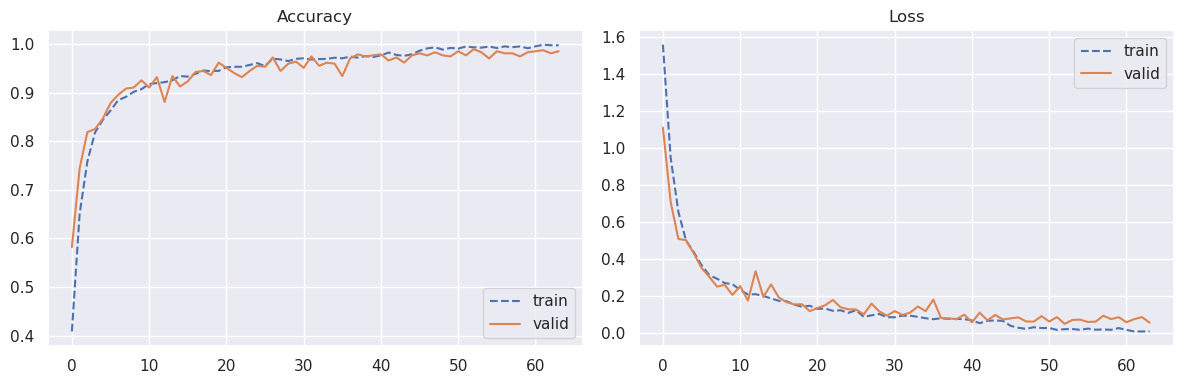

In [48]:
sns.set()
fig = pyplot.figure(0, (12, 4))

ax = pyplot.subplot(1, 2, 1)
sns.lineplot(x=history.epoch, y=history.history['accuracy'], label='train',linestyle='dashed')
sns.lineplot(x=history.epoch, y=history.history['val_accuracy'], label='valid')
pyplot.title('Accuracy')
pyplot.tight_layout()

ax = pyplot.subplot(1, 2, 2)
sns.lineplot(x=history.epoch, y=history.history['loss'], label='train', linestyle='dashed')
sns.lineplot(x=history.epoch, y=history.history['val_loss'], label='valid')
pyplot.title('Loss')
pyplot.tight_layout()

pyplot.savefig('epoch_history_dcnn.png')
pyplot.show()

In [43]:
df_accu = pd.DataFrame({
    'train': [x * 100 for x in history.history['accuracy']], 
    'valid': [x * 100 for x in history.history['val_accuracy']]
})
df_loss = pd.DataFrame({
    'train': history.history['loss'], 
    'valid': history.history['val_loss']
})
print (df_accu)
print (df_loss)

        train      valid
0   40.882143  58.208954
1   65.069956  74.413645
2   75.835901  81.876332
3   81.835431  82.515991
4   84.396487  84.648186
..        ...        ...
59  99.122602  98.294240
60  99.502015  98.507464
61  99.857718  98.720682
62  99.739152  98.081023
63  99.739152  98.507464

[64 rows x 2 columns]
       train     valid
0   1.558516  1.109832
1   0.949054  0.709226
2   0.653824  0.507591
3   0.497870  0.500891
4   0.435529  0.429009
..       ...       ...
59  0.025163  0.083795
60  0.015499  0.056758
61  0.006862  0.073597
62  0.006954  0.084628
63  0.007339  0.054671

[64 rows x 2 columns]


15/15 [==============================] - 1s 76ms/step


AttributeError: 'AxesSubplot' object has no attribute 'astype'

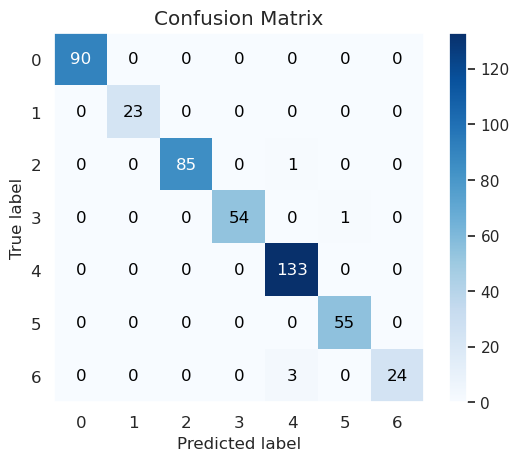

In [50]:
# Prédictions sur l'ensemble de validation
yhat_valid = np.argmax(model.predict(X_valid), axis=1)

# Calcul de la matrice de confusion
conf_matrix = scikitplot.metrics.plot_confusion_matrix(np.argmax(y_valid, axis=1), yhat_valid)

# Normalisation de la matrice de confusion en pourcentage
conf_matrix_percentage = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis] * 100

# Affichage de la matrice de confusion en pourcentage
skplt.metrics.plot_confusion_matrix(np.argmax(y_valid, axis=1), yhat_valid, figsize=(5,5), normalize=True)
pyplot.title("Confusion Matrix (in %)")
pyplot.savefig("confusion_matrix_dcnn.png")

# Affichage du nombre total de mauvaises prédictions
print(f'total wrong validation predictions: {np.sum(np.argmax(y_valid, axis=1) != yhat_valid)}\n\n')

# Affichage du rapport de classification
print(classification_report(np.argmax(y_valid, axis=1), yhat_valid))

15/15 [==============================] - 1s 77ms/step
total wrong validation predictions: 5


              precision    recall  f1-score   support

           0       1.00      1.00      1.00        90
           1       1.00      1.00      1.00        23
           2       1.00      0.99      0.99        86
           3       1.00      0.98      0.99        55
           4       0.97      1.00      0.99       133
           5       0.98      1.00      0.99        55
           6       1.00      0.89      0.94        27

    accuracy                           0.99       469
   macro avg       0.99      0.98      0.99       469
weighted avg       0.99      0.99      0.99       469



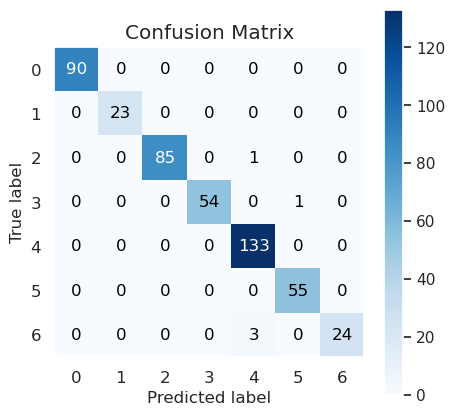

In [51]:
yhat_valid = np.argmax(model.predict(X_valid), axis=1)
scikitplot.metrics.plot_confusion_matrix(np.argmax(y_valid, axis=1), yhat_valid, figsize=(5,5))
pyplot.savefig("confusion_matrix_dcnn.png")

print(f'total wrong validation predictions: {np.sum(np.argmax(y_valid, axis=1) != yhat_valid)}\n\n')
print(classification_report(np.argmax(y_valid, axis=1), yhat_valid))

15/15 [==============================] - 1s 76ms/step
total wrong validation predictions: 5


              precision    recall  f1-score   support

           0       1.00      1.00      1.00        90
           1       1.00      1.00      1.00        23
           2       1.00      0.99      0.99        86
           3       1.00      0.98      0.99        55
           4       0.97      1.00      0.99       133
           5       0.98      1.00      0.99        55
           6       1.00      0.89      0.94        27

    accuracy                           0.99       469
   macro avg       0.99      0.98      0.99       469
weighted avg       0.99      0.99      0.99       469



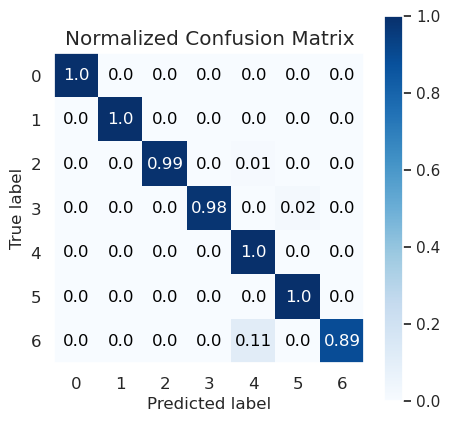

In [52]:
yhat_valid = np.argmax(model.predict(X_valid), axis=1)
scikitplot.metrics.plot_confusion_matrix(np.argmax(y_valid, axis=1), yhat_valid, normalize=True,figsize=(5,5))
pyplot.savefig("confusion_matrix_dcnn.png")

print(f'total wrong validation predictions: {np.sum(np.argmax(y_valid, axis=1) != yhat_valid)}\n\n')
print(classification_report(np.argmax(y_valid, axis=1), yhat_valid))

15/15 [==============================] - 1s 76ms/step


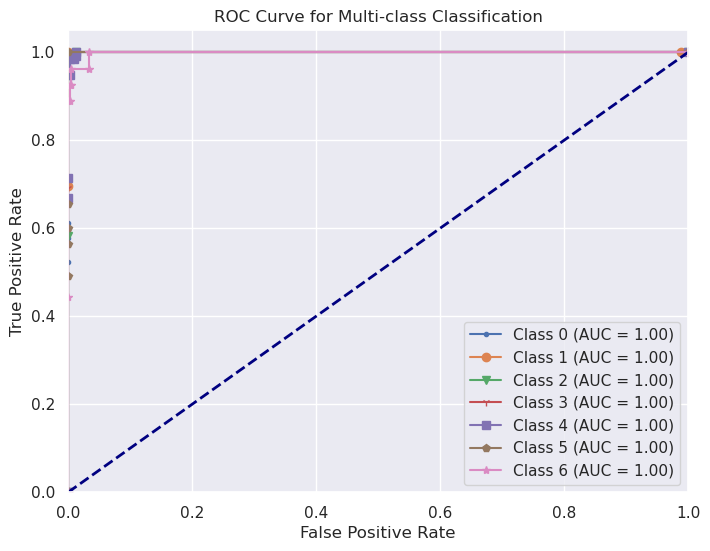

In [53]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

y_test_bin = label_binarize(y_valid, classes=np.arange(7))
#X_train, X_valid, y_train, y_valid
y_score = model.predict(X_valid)

for i in range(7):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot the ROC curve for each class
plt.figure(figsize=(8, 6))

markers = ['.','o','v','1','s','p','*','h']

for i in range(7):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})', marker=markers[i])

plt.plot([0, 1], [0, 1], color='navy', linestyle='--', linewidth=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multi-class Classification')
plt.legend(loc="lower right")
plt.show()

In [ ]:
loss, accuracy = model.evaluate(X_valid, y_valid)

# Not looking forward

In [ ]:
# Define the eye landmark indexes (based on Mediapipe's face mesh landmarks)
LEFT_EYE_LANDMARKS = [33, 133]  # Example: landmarks for left eye
RIGHT_EYE_LANDMARKS = [362, 263]  # Example: landmarks for right eye

def calculate_angle(eye_vector, camera_vector):
    """Calculate the angle between two vectors."""
    cos_theta = np.dot(eye_vector, camera_vector) / (np.linalg.norm(eye_vector) * np.linalg.norm(camera_vector))
    theta = np.arccos(np.clip(cos_theta, -1.0, 1.0))  # Clip to avoid numerical issues
    return np.degrees(theta)

# if theta <= 115 and theta >= 55 then the eye are looking forward

# If eye is open

In [ ]:
def eyeIsOpen2(faces, gray):
    
    # Loop through each face
    for face in faces:
        # Get the facial landmarks
        landmarks = predictor(gray, face)

        # Extract coordinates of the left and right eye
        left_eye = []
        right_eye = []
        for n in range(36, 42):
            x = landmarks.part(n).x
            y = landmarks.part(n).y
            left_eye.append((x, y))
        for n in range(42, 48):
            x = landmarks.part(n).x
            y = landmarks.part(n).y
            right_eye.append((x, y))

        # Convert eye coordinates to numpy arrays
        left_eye = np.array(left_eye)
        right_eye = np.array(right_eye)

        # Calculate eye aspect ratio (EAR)
        left_ear = eye_aspect_ratio(left_eye)
        right_ear = eye_aspect_ratio(right_eye)
        ear = (left_ear + right_ear) / 2.0

        # Define a threshold for closed eyes
        threshold = 0.1 #0.2
        thresholdAsleep = 0.2
        if ear < threshold:
            return 's'
        elif ear >= threshold and ear < threshold2:
            return 'as'
        else:
            return 'o'

# No Face Function

In [ ]:
def timeNoFace2(start_timeNoFace, prev_face_state, current_face_stat):
    # True is Face Exist and False is No Face detected
    # Return Local, StartTime
        
    if prev_face_state == True and current_face_stat==False:
        start_timeNoFace = time.time()
        return 0,start_timeNoFace  
    
    elif prev_face_state == False and current_face_stat==True:
        end_time = time.time()
        noFace_duration = end_time - start_timeNoFace
        return noFace_duration, 0
    
    else:
        if current_face_stat == False:
            return 0, start_timeNoFace
        else:
            return 0, 0

# Closed Eyes

In [ ]:
def timeClosed2(nbrFramesClosed, prev_eye_state, current_stat):
    # True is Open and False is Close
    # Return nbrFramesClosed
    
    if prev_eye_state == True and current_stat==False:
        nbrFramesClosed = 1
        return nbrFramesClosed  
    
    elif prev_eye_state == False and current_stat==True:
        return nbrFramesClosed
    
    else:
        if current_stat == False:
            nbrFramesClosed+=1
            return nbrFramesClosed
        else:
            return 0